In [1]:
import emcee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import corner
BDecLabel = "Log(H\u03B1/H\u03B2)"
LCO10Label = "Log(L CO $_{1-0}$)"
LCO21Label = "Log(L CO $_{2-1}$)"
MDustLabel = "Log(M$_{Dust}$/M$_*$)"
MH2Label = "Log(M H$_2$/M$_*$)"
StarMassLabel = "Log(M$_{Star}$/M$_*$)"
SFRLabel = "SFR"
GasFracLabel = "GasFrac"

/Users/sean/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Here's the deal!

MCMC Below is now working (dope!)

That means don't mess with anything below the following 3 cells.

In [2]:
# file io for x and y here

# M DUST
dfJingle = pd.read_csv("JINGLEMASTERDEC19.csv")
print(str(len(dfJingle["AGNCLASS"]))+" Members in JINGLE")

delindex = []

for i in range(len(dfJingle["N2HA"])):
    if np.asarray(dfJingle["AGNCLASS"])[i]!=1: # agn type filter
        delindex.append(i)
        print(i)
    elif np.asarray(dfJingle["Z"])[i]>0.06: # redshift filter
        print(i)
        delindex.append(i)
    elif np.asarray(dfJingle["HA SNR"][i])<5 or np.asarray(dfJingle["HB SNR"][i])<5: # removing bad SNR galaxies
        print(i)
        delindex.append(i)

dfJingle = dfJingle.drop(np.asarray(delindex)) # removing non SFing galaxies
dfJingle = dfJingle.drop([44]) # removing one nan that wouldn't come out of the dataset for whatever reason
print(str(len(dfJingle["AGNCLASS"]))+" Members in JINGLE")


# LCO and MH2
dfXCold = pd.read_csv("xColdFilt.csv")
print(str(len(dfXCold["AGNCLASS"]))+" Members in xCOLD")

# STARMASS
# mpamaster = pd.read_csv("MPAMaster.csv")
# print(str(len(mpamaster["Z"]))+" Members in MPA sample")
# for i in range(len(mpamaster["GALAXY CLASS"])):
#     if mpamaster["GALAXY CLASS"][i]!=1:
#         print(mpamaster["GALAXY CLASS"][i]) # This ensures no non-SFing galaxies

delindex = []
for i in range(len(dfXCold)):
    if dfXCold["LOGMH2"][i]<=5:
        delindex.append(i)
dfXCold = dfXCold.drop(delindex) # removing 0's in log MH2

# print(dfJingle.columns.values)
# print(dfXCold.columns.values)
# print(mpamaster.columns.values)

117 Members in JINGLE
20
115 Members in JINGLE
126 Members in xCOLD


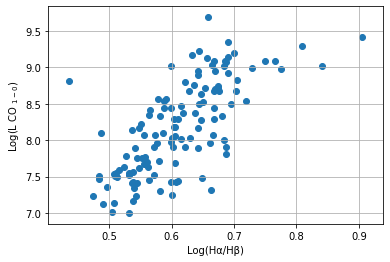

In [11]:
x = np.asarray(dfXCold["BALMER"]) # set x variable here
y = np.asarray(dfXCold["LOGLCO"]) # set y variable here

xerr = np.asanyarray(dfXCold["BALMER_ERR"]) # set x err here
yerr = np.asanyarray(dfXCold["LOGLCO_ERR"]) # set y err here

# Z = np.asarray(mpamaster["Z"])

xlab = BDecLabel # set x label here
ylab = LCO10Label # set y label here

fname = "BDECvsLCO10"

plt.scatter(x,y)
plt.grid()
# plt.ylim(7.8,10.1)
# plt.colorbar()
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.show()

In [6]:
m_guess = 2.59 # make guesses here
b_guess = 6.16
logf_guess = -1
stepnum = 10**6 # set stupnumber and burnin below
burnin = int(0.05*stepnum)

m_prior_range = [0,25] # set ranges here
b_prior_range = [2,25]
lnf_prior_range = [-5,5]

### Just run everything below here

In [7]:
min_y = 7
max_y = 9
min_x = 0.45
max_x = 1

N = len(x)

mctitle = xlab+" vs. "+ylab +" MCMC fit with "+str(stepnum)+" steps"

S = np.zeros((N,2,2))
for l in range(N):
    S[l][0][0] = xerr[l]
    S[l][1][1] = yerr[l]

def plot_samples_full(sampler, ndim, l): # plots the traceplot
    fig, axes = plt.subplots(ndim, figsize=(10, 10), sharex=True)
    samples = sampler.get_chain()
    labels = l
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, burnin+stepnum)
#         ax.grid()
        ax.axvline(burnin,ls="--",c="black")
        ax.set_ylabel(labels[i])
    axes[-1].set_xlabel("step number");
    plt.savefig(fname + '_chains.png', dpi=100)
    plt.show()

def plot_corner_full2(samples_input, labels): # plots the corner plot
#     samples_input[2,:] = np.exp(samples_input[2,:])
    fig, ax = plt.subplots(nrows = 3, ncols = 3, squeeze=False, figsize=(6,6))
    corner.corner(samples_input,
                  labels=labels,
                  truths=(np.median(samples_input[:,0]),
                  np.median(samples_input[:, 1]),
                  np.median(np.log10(samples_input[:, 2]))),
                  truth_color="k",
                  quantiles=[0.16, 0.84], show_titles=True, title_kwargs={"fontsize": 12},fig=fig)
    fig.set_size_inches(w=10,h=10)
    plt.savefig(fname+"_corner.png", dpi=100)
    plt.show()

def plot_results(samples2, x, y , xerr, yerr): # plots the scatter plot with 100 random lines from the chain
    fig, ax = plt.subplots(nrows = 1, ncols = 1, squeeze=False, figsize=(6,6))
    # plot the data
    ax[0,0].errorbar(x, y, xerr = xerr, yerr = yerr, fmt = 'o',c="red")
    x = np.linspace(min_x, max_x, 200)
    # plot 100 random draws from the converged chain with intrinsic scatter
    for params in samples2[np.random.randint(len(samples2), size=100)]:
        h1, h2, lnh = params
        ax[0,0].plot(x, h1*x + h2, color = 'b', alpha = 0.1)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(mctitle)
    plt.grid()
    plt.xlim(min_x,max_x)
    plt.ylim(min_y,max_y)
#     plt.legend()
    fig.set_size_inches(w=10,h=10)
    plt.savefig(fname+".png",dpi=100)
    plt.show()
    

# Stuff below here is straight line specific

def straight_line(x, params):
    m, b = params
    return (m*x) + b


def straight_line_params2(params):
    m, b, lnf = params
    # uniform flat priors on m and b between these ranges (can vary these)
    if  m_prior_range[0] < m < m_prior_range[1] and b_prior_range[0] < b < b_prior_range[1] and lnf_prior_range[0] < lnf < lnf_prior_range[1]:
        return 0
    # if the params drawn outside the above ranges we make it very unlikely
    return -np.inf

def log_likelihood_straight_line2(params):
    # log likelihood explained in: https://dfm.io/posts/fitting-a-plane/ (Eq 14-16)
    m, b, lnf = params
    params2 = m, b
    v = np.array([-m, 1.0])
    model = straight_line(x, params2)
    deltaN = y - model
    sigma_sq = np.square(xerr*m) + np.square(yerr) + np.exp(2*lnf)
    log_likelihood = -0.5 * np.sum((np.square(deltaN)/sigma_sq) + np.log(sigma_sq)) # this line
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    return log_likelihood + straight_line_params2(params)

In [8]:
#-------------------------------------------------------------------------------
# emcee inference for straight line (intrinsic scatter)
#-------------------------------------------------------------------------------
# set the number of dimensions (2 parameters) and number of walkers
ndim, nwalkers = 3, 100
# initial guess for the slope and y-intercept
g2 = [m_guess, b_guess, logf_guess]
# param labels to send to plot functions
param_labels = ['m', 'b', 'ln(f)']
# make a cluster of pts around the guesses for the walkers
pos2 = [g2 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
# setup emcee to run with 'log_likelihood_straight_line2' function as the log likelihood
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_straight_line2)
# run emcee for n steps
sampler2.run_mcmc(pos2, stepnum+burnin, progress=True)
# print the acceptance fraction to give us an idea whether it is working
af = sampler2.acceptance_fraction
print("Mean acceptance fraction:", np.mean(af))
# take only values after the chain has converged
samples2 = sampler2.chain[:, burnin:, :].reshape((-1, ndim)) # burn in??

/Users/sean/anaconda3/lib/python3.6/site-packages/emcee-3.0.0-py3.6.egg/emcee/ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  0%|          | 3621/1050000 [00:14<1:11:31, 243.84it/s]


KeyboardInterrupt: 

In [ ]:
# make a corner plot for chain after convergence
plot_corner_full2(samples2, param_labels)

In [ ]:
plot_results(samples2, x, y , xerr, yerr) # plot your results here

In [ ]:
# use function to plot the chain for each parameter to see if/when it converged
plot_samples_full(sampler2, ndim, param_labels)